In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                  # Step 1: Resize to 224x224
    transforms.Grayscale(num_output_channels=3),    # Step 2: Convert 1→3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Load datasets
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.4MB/s]


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

model = models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [5]:
# This keeps all convolutional layers but discards the final 1000-class classifier
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [6]:
# Freeze all layers in the backbone (no gradients will be computed)
for param in model.parameters():
    param.requires_grad = False

In [7]:
# Define a new classifier head
class FashionMNISTHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 512)  # ResNet50 backbone outputs 2048 features
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)    # 10 classes for Fashion-MNIST

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [8]:
full_model = nn.Sequential(
    model,          # Frozen ResNet50 backbone (outputs 2048-dim features)
    FashionMNISTHead()  # Trainable head
)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
full_model = full_model.to(device)

# Loss and optimizer (only train the head!)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(full_model[-1].parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    full_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = full_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation phase
    full_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = full_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct / total

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Epoch 1: 100%|██████████| 1875/1875 [04:24<00:00,  7.08it/s]


Epoch 1: Train Loss: 0.6376, Train Acc: 77.24%, Val Loss: 0.4357, Val Acc: 84.07%


Epoch 2: 100%|██████████| 1875/1875 [04:25<00:00,  7.07it/s]


Epoch 2: Train Loss: 0.4770, Train Acc: 82.49%, Val Loss: 0.4161, Val Acc: 84.54%


Epoch 3: 100%|██████████| 1875/1875 [04:24<00:00,  7.09it/s]


Epoch 3: Train Loss: 0.4449, Train Acc: 83.62%, Val Loss: 0.3966, Val Acc: 85.48%


Epoch 4: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]


Epoch 4: Train Loss: 0.4225, Train Acc: 84.36%, Val Loss: 0.3875, Val Acc: 85.85%


Epoch 5: 100%|██████████| 1875/1875 [04:28<00:00,  6.99it/s]


Epoch 5: Train Loss: 0.4007, Train Acc: 85.20%, Val Loss: 0.4079, Val Acc: 85.05%


In [16]:
# Save the trained model after head training (Part b)
torch.save(full_model.state_dict(), 'resnet_fashionmnist_head_train.pth')
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [17]:
import torch
import torch.nn as nn
from torchvision import models
import os # Import os for the check

model = models.resnet50(weights='DEFAULT')

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

modules = list(model.children())[:-1]
backbone = nn.Sequential(*modules)

head = FashionMNISTHead()


full_model = nn.Sequential(
    backbone,
    head
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
full_model = full_model.to(device)

# Load saved weights
save_path = 'resnet_fashionmnist_head_train.pth'
if os.path.exists(save_path):
    full_model.load_state_dict(torch.load(save_path))
    print("✅ Pretrained head model loaded successfully!")
else:
    print(f"❌ Error: Model file not found at {save_path}. Please run the saving cell first.")

✅ Pretrained head model loaded successfully!


In [18]:
for name, param in full_model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: 0.7.0.conv1.weight
Trainable: 0.7.0.bn1.weight
Trainable: 0.7.0.bn1.bias
Trainable: 0.7.0.conv2.weight
Trainable: 0.7.0.bn2.weight
Trainable: 0.7.0.bn2.bias
Trainable: 0.7.0.conv3.weight
Trainable: 0.7.0.bn3.weight
Trainable: 0.7.0.bn3.bias
Trainable: 0.7.0.downsample.0.weight
Trainable: 0.7.0.downsample.1.weight
Trainable: 0.7.0.downsample.1.bias
Trainable: 0.7.1.conv1.weight
Trainable: 0.7.1.bn1.weight
Trainable: 0.7.1.bn1.bias
Trainable: 0.7.1.conv2.weight
Trainable: 0.7.1.bn2.weight
Trainable: 0.7.1.bn2.bias
Trainable: 0.7.1.conv3.weight
Trainable: 0.7.1.bn3.weight
Trainable: 0.7.1.bn3.bias
Trainable: 0.7.2.conv1.weight
Trainable: 0.7.2.bn1.weight
Trainable: 0.7.2.bn1.bias
Trainable: 0.7.2.conv2.weight
Trainable: 0.7.2.bn2.weight
Trainable: 0.7.2.bn2.bias
Trainable: 0.7.2.conv3.weight
Trainable: 0.7.2.bn3.weight
Trainable: 0.7.2.bn3.bias
Trainable: 1.fc1.weight
Trainable: 1.fc1.bias
Trainable: 1.fc2.weight
Trainable: 1.fc2.bias


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(filter(lambda p: p.requires_grad, full_model.parameters()), lr=1e-4, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Loss function
criterion = nn.CrossEntropyLoss()


In [20]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    full_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
        images, labels = images.to(device), labels.to(device)

        outputs = full_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    full_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Epoch {epoch+1} Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = full_model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Step the learning rate scheduler
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}]: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Epoch 1 Validation: 100%|██████████| 313/313 [00:42<00:00,  7.32it/s]


Epoch [1/5]: Train Loss: 0.4001, Train Acc: 86.08%, Val Loss: 0.2639, Val Acc: 90.27%


Epoch 2 Validation: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


Epoch [2/5]: Train Loss: 0.1937, Train Acc: 93.04%, Val Loss: 0.2470, Val Acc: 91.23%


Epoch 3 Validation: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


Epoch [3/5]: Train Loss: 0.1229, Train Acc: 95.63%, Val Loss: 0.2470, Val Acc: 91.75%


Epoch 4 Validation: 100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


Epoch [4/5]: Train Loss: 0.0451, Train Acc: 98.56%, Val Loss: 0.2629, Val Acc: 92.24%


Epoch 5 Validation: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]

Epoch [5/5]: Train Loss: 0.0247, Train Acc: 99.23%, Val Loss: 0.2838, Val Acc: 92.49%


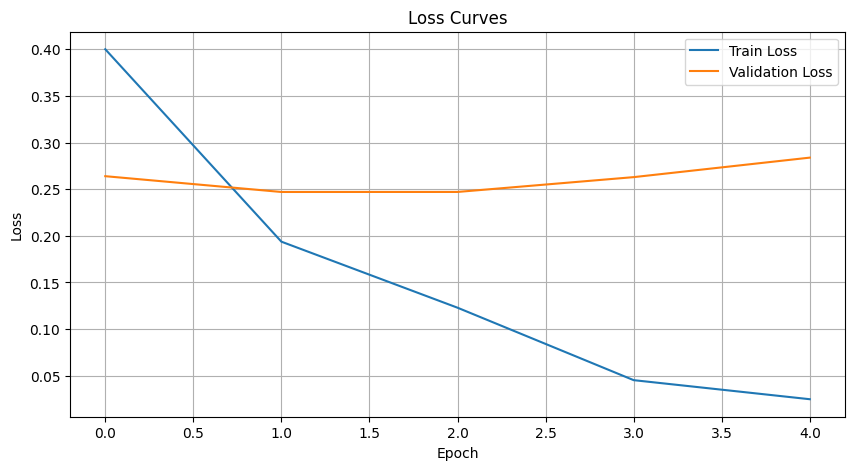

In [22]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

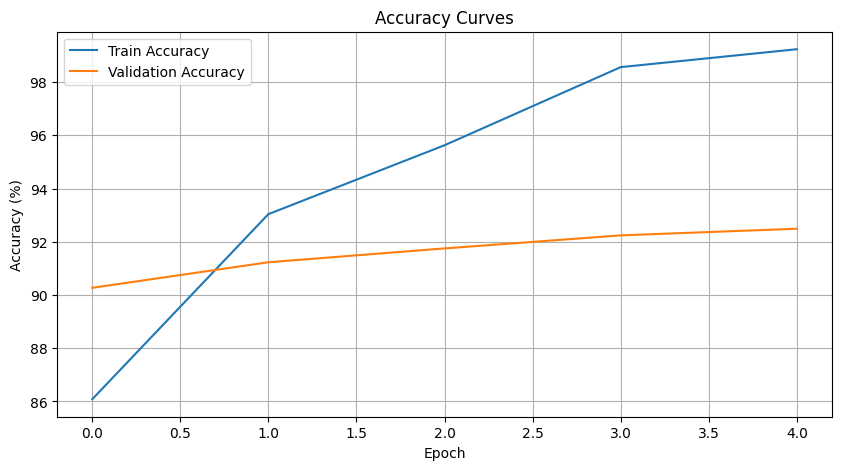

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()
plt.grid()
plt.show()

In [24]:
torch.save(full_model.state_dict(), 'resnet_fashionmnist_fronzen_layer_train.pth')
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set model to evaluation mode
full_model.eval()

test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Final Testing'):
        images, labels = images.to(device), labels.to(device)
        outputs = full_model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total

print(f'\n✅ Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Final Testing: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


✅ Final Test Loss: 0.2838, Test Accuracy: 92.49%



📊 Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.89      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.89      0.88      0.88      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.88      0.90      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.80      0.77      0.78      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



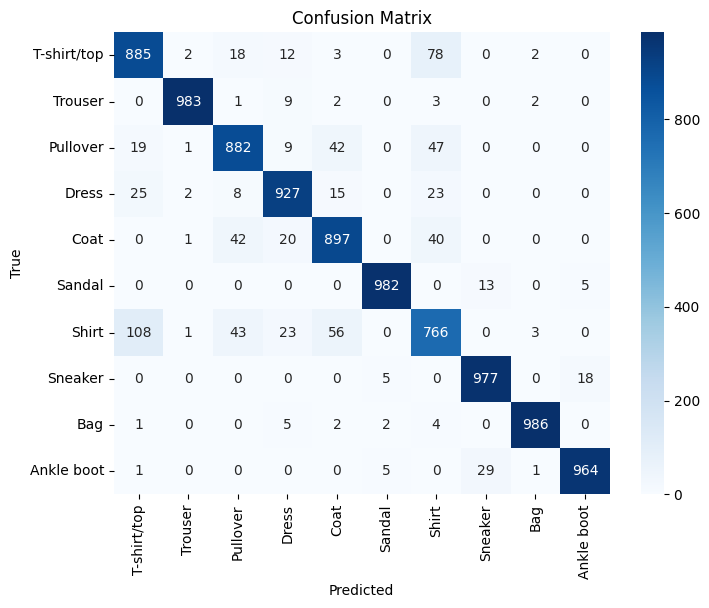

In [26]:
# Assuming 10 classes for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

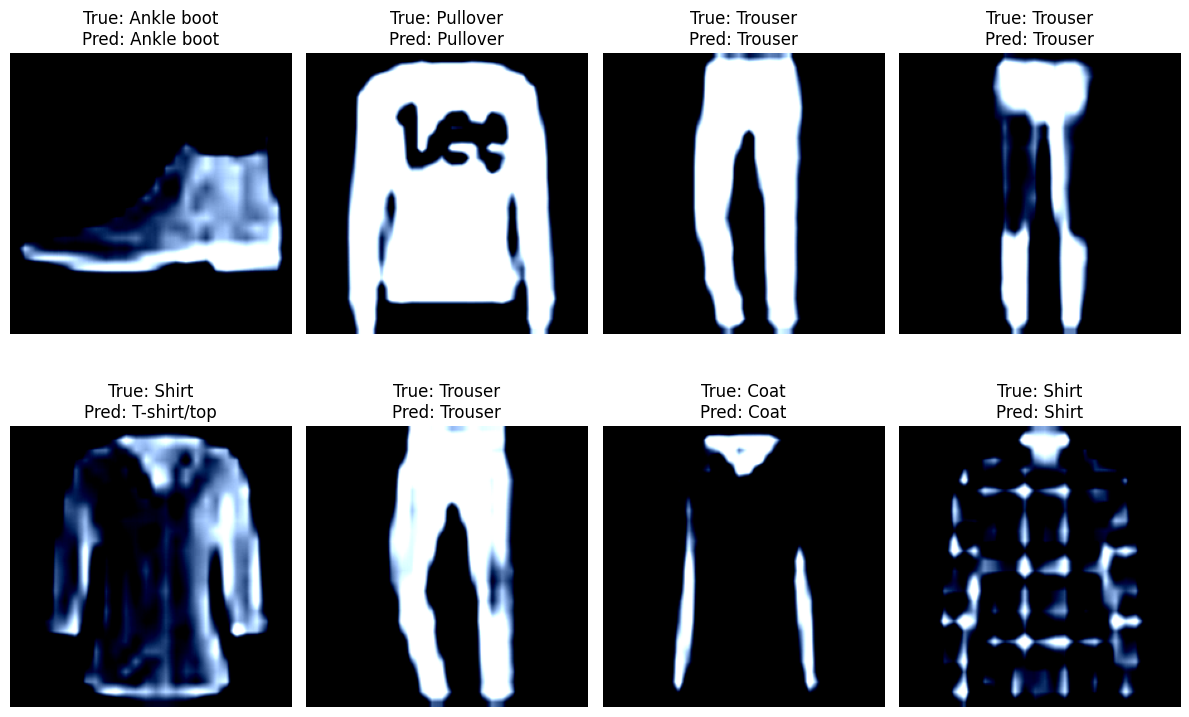

In [27]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

full_model.eval()


dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = full_model(images)


_, predicted = torch.max(outputs, 1)


fig = plt.figure(figsize=(12, 8))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1)
    img = images[idx].cpu().permute(1, 2, 0).numpy()
    img = img.squeeze()

    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predicted[idx]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()